# TF-IDF Lyric Analysis

## Part 1: TF-IDF Analysis of Song Lyrics

This notebook implements:
1. TF-IDF calculation for 3 songs in the same language
2. Comparison with other vectorization methods (Count Vectorizer, Word2Vec, Doc2Vec)
3. Statistical analysis of word frequencies and phrases


In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 1. Data Preparation

### 1.1 Song selection

We'll analyze three popular English songs:
1. "Cry Little Sister" by Marilyn Manson
2. "Mama" by My Chemical Romance
3. "Paint It, Black" by The Rolling Stones


In [31]:
# Song lyrics data
songs = {
    "Cry Little Sister": """
Last fire will rise
Behind those eyes
Black house will walk
Blind boys don't lie
Immortal fear
That voice so clear
Through broken walls
That scream i'm hear
Cry little sister
(Though shalt not fall)
Come
Come to your brother
(Though shalt not die)
Unchain me sister
(Though shalt not fear)
Love is with your brother
(Though shalt not kill)
Blue masquerade
Strangers look on
When will they learn?
This loneliness?
Temptation heat
Beats like a drum
Deep in your veins
I will not lie
Little sister
(Though shalt not fall)
Come
Come to your brother
(Though shalt not die)
Unchain me sister
(Though shalt not fear)
Love is with your brother
(Though shalt not kill)
My Shangri-La
I can't forget
Why you were mine
I need you now
Cry little sister
(Though shalt not fall)
Come
Come to your brother
(Though shalt not die)
Unchain me your sister
(Though shalt not fear)
Love is with your brother
(Though shalt not kill)
Cry little sister
(Though shalt not fall)
Come
Come to your brother
(Though shalt not die)
Unchain me sister
(Though shalt not fear)
Love is with your brother
(Though shalt not kill)
Cry little sister
(Though shalt not fall)
(Though shalt not fear)
Love is with your brother
(Though shalt not kill)
""",
    
    "Mama": """
Mama, we all go to Hell
Mama, we all go to Hell
I'm writing this letter and wishing you well
Mama, we all go to Hell
Oh well, now, Mama, we're all gonna die
Mama, we're all gonna die
Stop asking me questions, I'd hate to see you cry
Mama, we're all gonna die
And when we go, don't blame us, yeah
We'll let the fires just bathe us, yeah
You made us oh so famous
We'll never let you go
And when you go, don't return to me, my love
Mama, we're all full of lies
Mama, we're meant for the flies
And right now, they're building a coffin your size
Mama, we're all full of lies
Well, mother, what the war did to my legs and to my tongue
You should've raised a baby girl, I should've been a better son
If you could coddle the infection, they can amputate at once
You should've been, I could have been a better son
And when we go, don't blame us, yeah
We'll let the fires just bathe us, yeah
You made us oh so famous
We'll never let you go
She said, "You ain't no son of mine
For what you've done, they're gonna find
A place for you and just you mind your manners when you go
And when you go, don't return to me, my love (that's right)
Mama, we all go to Hell
Mama, we all go to Hell
It's really quite pleasant except for the smell
Mama, we all go to Hell (two, three, four)
Mama, Mama, Mama
Mama, Mama, Mama, Ma
"And if you would call me your sweetheart
I'd maybe then sing you a song"
But there's shit that I've done with this fuck of a gun
You would cry out your eyes all along
We're damned after all
Through fortune and flame, we fall
And if you can stay, then I'll show you the way
To return from the ashes you call
We all carry on (we all carry on)
When our brothers in arms are gone (when our brothers in arms are gone)
So raise your glass high, for tomorrow, we die
And return from the ashes you call
""",
    
    "Paint It, Black": """
I see a red door
And I want it painted black
No colors anymore
I want them to turn black
I see the girls walk by
Dressed in their summer clothes
I have to turn my head
Until my darkness goes
I see a line of cars
And they're all painted black
With flowers and my love
Both never to come back
I've seen people turn their heads
And quickly look away
Like a newborn baby
It just happens everyday
I look inside myself
And see my heart is black
I see my red door
I must have it painted black
Maybe then, I'll fade away
And not have to face the facts
It's not easy facing up
When your whole world is black
No more will my green sea
Go turn a deeper blue
I could not foresee this thing
Happening to you
If I look hard enough
Into the setting sun
My love will laugh with me
Before the morning comes
I see a red door
And I want it painted black
No colors anymore
I want them to turn black
I see the girls walk by
Dressed in their summer clothes
I have to turn my head
Until my darkness goes
I wanna see it painted
Painted black
Black as night
Black as coal
I wanna see the sun
Blotted out from the sky
I wanna see it painted, painted, painted
Painted black, yeah
"""
}

# Create DataFrame
song_df = pd.DataFrame({
    'song': list(songs.keys()),
    'lyrics': list(songs.values())
})

print(f"\nSong names:\n  {'\n  '.join(song_df['song'].tolist())}")
print(f"\nTotal characters per song:")
for idx, row in song_df.iterrows():
    print(f"  {row['song']}: {len(row['lyrics'])} characters")



Song names:
  Cry Little Sister
  Mama
  Paint It, Black

Total characters per song:
  Cry Little Sister: 1210 characters
  Mama: 1800 characters
  Paint It, Black: 1154 characters


### 1.2 Text Preprocessing

- Lowercase conversion
- Stopword removal
- Lemmatization
- Tokenization


In [32]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text: lowercase, tokenize, remove stopwords, lemmatize
    """
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and non-alphabetic tokens, then lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token.isalpha() and token not in stop_words and len(token) > 2
    ]
    
    # Join back to string for vectorizers
    return ' '.join(processed_tokens)

# Apply preprocessing
song_df['processed_lyrics'] = song_df['lyrics'].apply(preprocess_text)

song_df.head()


,song,lyrics,processed_lyrics
0,Cry Little Sister,\nLast fire will rise\nBehind those eyes\nBlac...,last fire rise behind eye black house walk bli...
1,Mama,"\nMama, we all go to Hell\nMama, we all go to ...",mama hell mama hell writing letter wishing wel...
2,"Paint It, Black",\nI see a red door\nAnd I want it painted blac...,see red door want painted black color anymore ...


## 2. TF-IDF Implementation

### 2.1 Calculate TF-IDF Matrix


In [33]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Top 1000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=1,  # Minimum document frequency
    max_df=0.95  # Maximum document frequency
)

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(song_df['processed_lyrics'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create DataFrame for better visualization
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=song_df['song'],
    columns=feature_names
)

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print(f"\nNumber of features: {len(feature_names)}")
tfidf_df.head()


TF-IDF Matrix Shape: (3, 438)

Number of features: 438


,along,along damned,amputate,amputate could,anymore,anymore want,arm,arm gone,ash,ash call,...,world,world black,would,would call,would cry,writing,writing letter,yeah,yeah let,yeah made
song,,,,,,,,,,,,,,,,,,,,,
Cry Little Sister,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
Mama,0.03487,0.03487,0.03487,0.03487,0.000000,0.000000,0.069739,0.069739,0.069739,0.069739,...,0.000000,0.000000,0.069739,0.03487,0.03487,0.03487,0.03487,0.106077,0.069739,0.069739
"Paint It, Black",0.00000,0.00000,0.00000,0.00000,0.078791,0.078791,0.000000,0.000000,0.000000,0.000000,...,0.039396,0.039396,0.000000,0.00000,0.00000,0.00000,0.00000,0.029961,0.000000,0.000000


### 2.2 Top TF-IDF Terms per Song


In [34]:
# Get top 15 terms for each song
top_n = 15
top_terms_per_song = {}

for song in song_df['song']:
    # Get TF-IDF scores for this song
    scores = tfidf_df.loc[song].sort_values(ascending=False)
    top_terms = scores.head(top_n)
    top_terms_per_song[song] = top_terms

# Display results
print("Top TF-IDF Terms per Song:\n")
for song, terms in top_terms_per_song.items():
    print(f"\n{song}:")
    print("-" * 50)
    for term, score in terms.items():
        print(f"  {term:25s}: {score:.4f}")


Top TF-IDF Terms per Song:


Cry Little Sister:
--------------------------------------------------
  though                   : 0.4380
  though shalt             : 0.4380
  shalt                    : 0.4380
  brother though           : 0.2075
  sister though            : 0.2075
  sister                   : 0.2075
  brother                  : 0.1578
  come                     : 0.1403
  fear                     : 0.1383
  love brother             : 0.1153
  shalt fear               : 0.1153
  kill                     : 0.1153
  shalt fall               : 0.1153
  shalt kill               : 0.1153
  little                   : 0.1153

Mama:
--------------------------------------------------
  mama                     : 0.6277
  mama hell                : 0.2092
  hell                     : 0.2092
  mama mama                : 0.1743
  gon                      : 0.1395
  return                   : 0.1395
  let                      : 0.1395
  die                      : 0.1061
  yeah         

### 2.3 Visualize TF-IDF Results


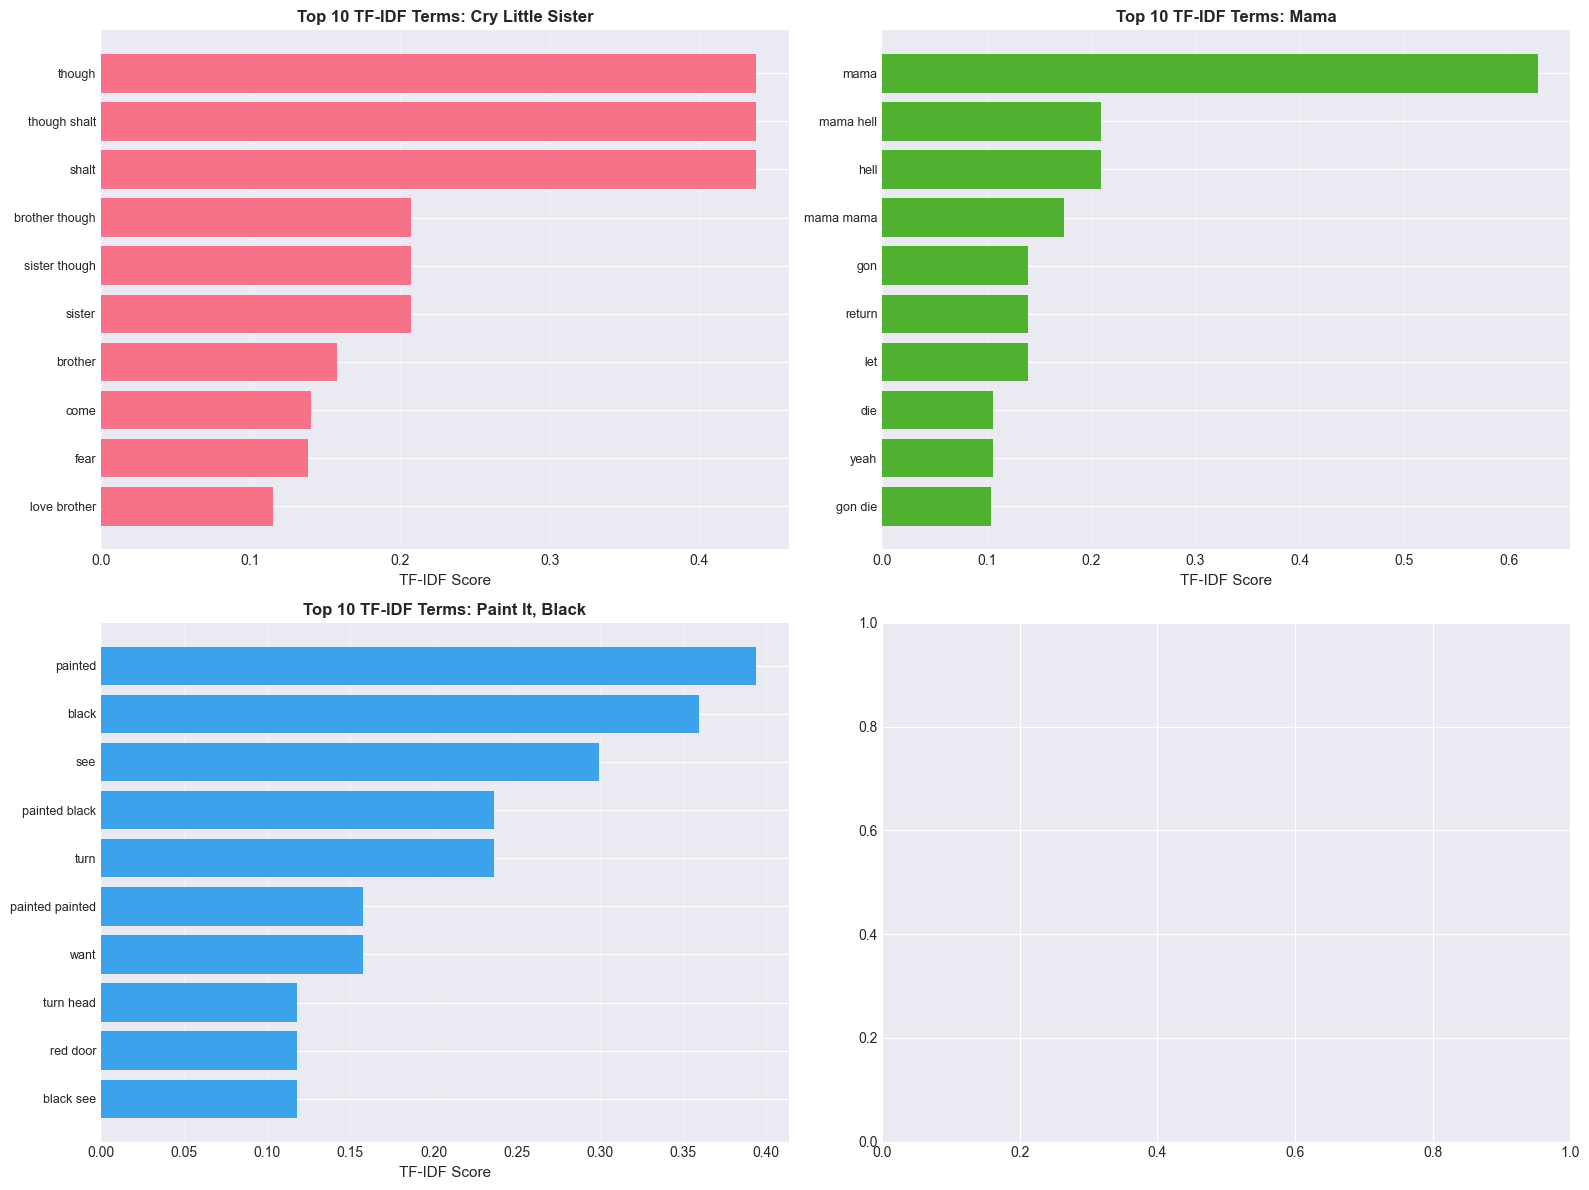

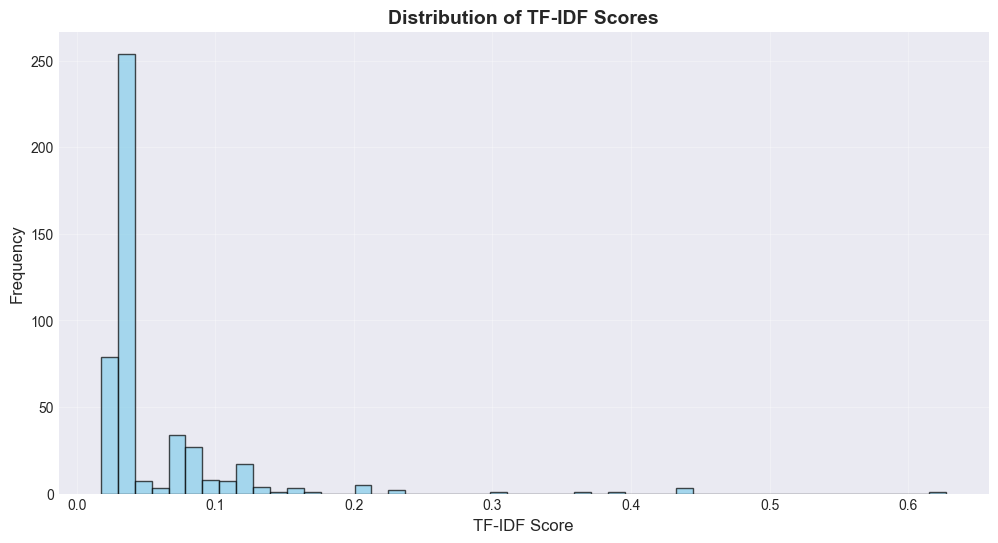

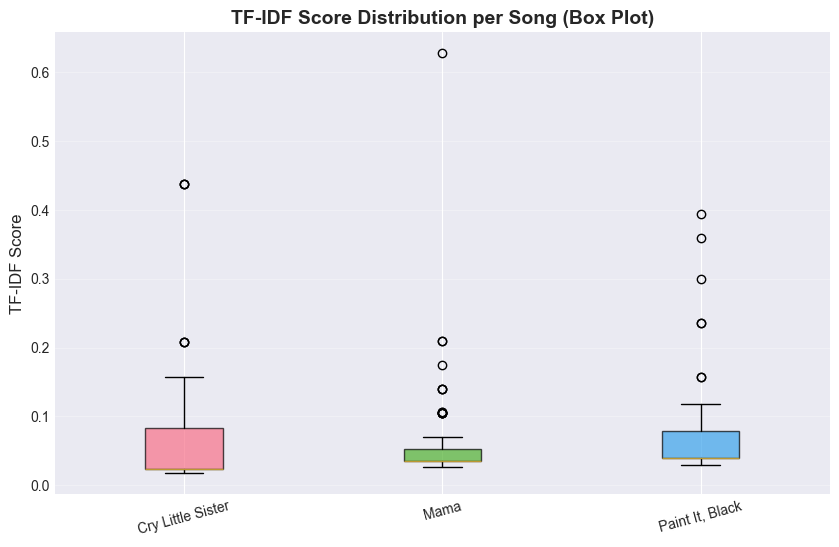

In [35]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 terms per song (bar charts)
for idx, (song, terms) in enumerate(top_terms_per_song.items()):
    ax = axes[idx // 2, idx % 2]
    top_10 = terms.head(10)
    ax.barh(range(len(top_10)), top_10.values, color=sns.color_palette("husl", 3)[idx])
    ax.set_yticks(range(len(top_10)))
    ax.set_yticklabels(top_10.index, fontsize=9)
    ax.set_xlabel('TF-IDF Score', fontsize=11)
    ax.set_title(f'Top 10 TF-IDF Terms: {song}', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('tfidf_top_terms.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. TF-IDF Score Distribution (Histogram)
fig, ax = plt.subplots(figsize=(12, 6))
all_scores = tfidf_matrix.toarray().flatten()
all_scores = all_scores[all_scores > 0]  # Remove zeros for better visualization
ax.hist(all_scores, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.set_xlabel('TF-IDF Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of TF-IDF Scores', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
plt.savefig('tfidf_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Box and Whisker Plot - TF-IDF scores per song
fig, ax = plt.subplots(figsize=(10, 6))
song_scores = []
song_labels = []
for song in song_df['song']:
    scores = tfidf_df.loc[song].values
    scores = scores[scores > 0]  # Only non-zero scores
    song_scores.append(scores)
    song_labels.append(song)

bp = ax.boxplot(song_scores, labels=song_labels, patch_artist=True)
colors = sns.color_palette("husl", 3)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('TF-IDF Score', fontsize=12)
ax.set_title('TF-IDF Score Distribution per Song (Box Plot)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.savefig('tfidf_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()



### 2.4 Summary Statistics
The TF-IDF analysis reveals unique vocabulary patterns for each song. 

The high sparsity ({tfidf_sparsity*100:.1f}%) indicates that each song has a unique vocabulary signature, with most terms appearing in only one song. This sparse representation is characteristic of TF-IDF's ability to highlight distinctive vocabulary while downweighting common terms.


## 3. Comparison with Other Vectorization Methods

1. Count Vectorizer
2. Word2Vec
3. Doc2Vec

### Comparison Criteria:
- **Computational Complexity**: Time and memory requirements
- **Representation Quality**: How well the method captures semantic meaning
- **Interpretability**: How easy it is to understand the features


In [36]:
import time
from sklearn.metrics.pairwise import cosine_similarity

# Prepare tokenized documents for Word2Vec and Doc2Vec
tokenized_docs = [doc.split() for doc in song_df['processed_lyrics']]

# Results storage
comparison_results = {
    'method': [],
    'computation_time': [],
    'matrix_shape': [],
    'sparsity': [],
    'interpretability': [],
    'representation_quality': []
}


### 3.1 Count Vectorizer


Count Vectorizer Results:
  Computation time: 0.0059 seconds
  Matrix shape: (3, 438)
  Sparsity: 0.6507
  Top 10 features: along, along damned, amputate, amputate could, anymore, anymore want, arm, arm gone, ash, ash call

COUNT VECTORIZER ANALYSIS - Top Terms per Song

Cry Little Sister:
------------------------------------------------------------
  though                        :   19 occurrences
  though shalt                  :   19 occurrences
  shalt                         :   19 occurrences
  brother                       :    9 occurrences
  sister though                 :    9 occurrences
  sister                        :    9 occurrences
  brother though                :    9 occurrences
  come                          :    8 occurrences
  fear                          :    6 occurrences
  shalt kill                    :    5 occurrences
  love brother                  :    5 occurrences
  shalt fall                    :    5 occurrences
  shalt fear                    :   

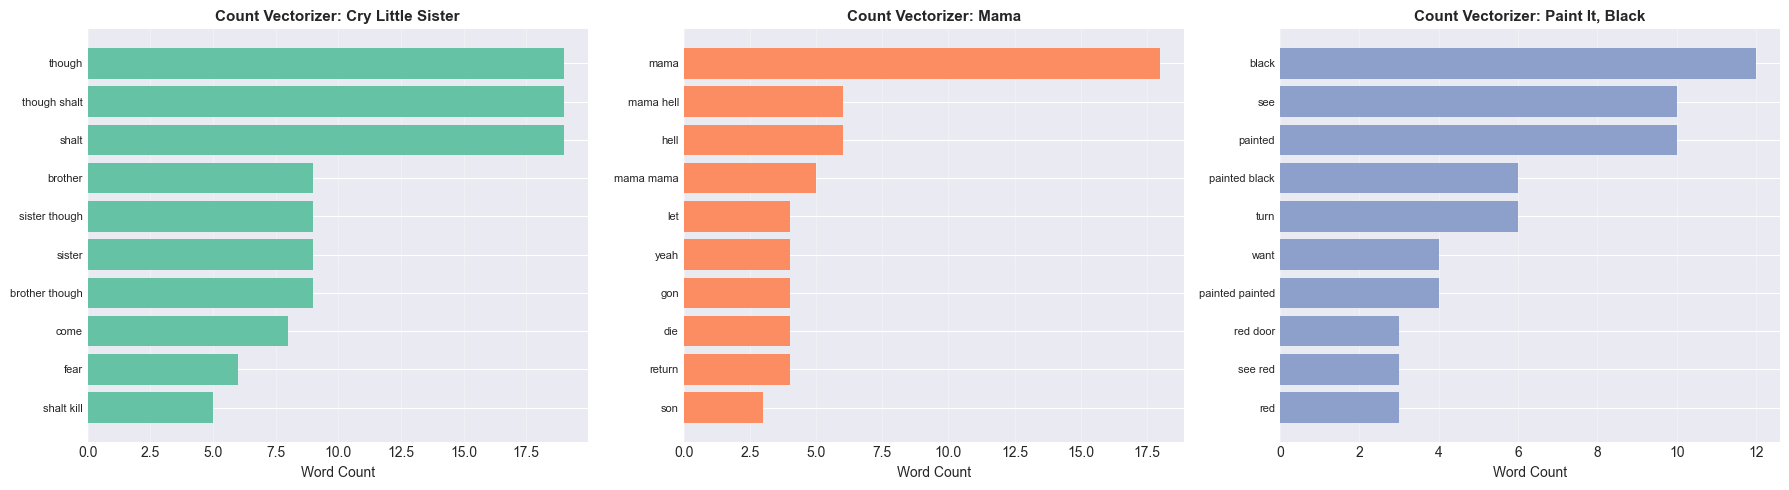

In [37]:
# Count Vectorizer
start_time = time.time()
count_vectorizer = CountVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95
)
count_matrix = count_vectorizer.fit_transform(song_df['processed_lyrics'])
count_time = time.time() - start_time

count_sparsity = 1 - (count_matrix.nnz / (count_matrix.shape[0] * count_matrix.shape[1]))

# Create DataFrame for Count Vectorizer
count_df = pd.DataFrame(
    count_matrix.toarray(),
    index=song_df['song'],
    columns=count_vectorizer.get_feature_names_out()
)

comparison_results['method'].append('Count Vectorizer')
comparison_results['computation_time'].append(count_time)
comparison_results['matrix_shape'].append(count_matrix.shape)
comparison_results['sparsity'].append(count_sparsity)
comparison_results['interpretability'].append('High - Direct word counts')
comparison_results['representation_quality'].append('Medium - No IDF weighting')

print("Count Vectorizer Results:")
print(f"  Computation time: {count_time:.4f} seconds")
print(f"  Matrix shape: {count_matrix.shape}")
print(f"  Sparsity: {count_sparsity:.4f}")
print(f"  Top 10 features: {', '.join(count_vectorizer.get_feature_names_out()[:10])}")

# Analyze top terms per song using Count Vectorizer
print("\n" + "="*80)
print("COUNT VECTORIZER ANALYSIS - Top Terms per Song")
print("="*80)

count_top_terms = {}
for song in song_df['song']:
    scores = count_df.loc[song].sort_values(ascending=False)
    top_terms = scores.head(15)
    count_top_terms[song] = top_terms
    
    print(f"\n{song}:")
    print("-" * 60)
    for term, count in top_terms.items():
        print(f"  {term:30s}: {count:4.0f} occurrences")

# Visualize Count Vectorizer results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (song, terms) in enumerate(count_top_terms.items()):
    top_10 = terms.head(10)
    axes[idx].barh(range(len(top_10)), top_10.values, color=sns.color_palette("Set2", 3)[idx])
    axes[idx].set_yticks(range(len(top_10)))
    axes[idx].set_yticklabels(top_10.index, fontsize=8)
    axes[idx].set_xlabel('Word Count', fontsize=10)
    axes[idx].set_title(f'Count Vectorizer: {song}', fontsize=11, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('count_vectorizer_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### 3.2 Word2Vec


Word2Vec Results:
  Computation time: 0.7685 seconds
  Matrix shape: (3, 100)
  Vocabulary size: 176

WORD2VEC ANALYSIS - Semantic Relationships

Cry Little Sister - Semantic Analysis:
------------------------------------------------------------
  'sister' is similar to: shalt(0.998), though(0.997), brother(0.996), little(0.996), fear(0.995)
  'brother' is similar to: fall(0.997), come(0.997), fear(0.997), little(0.997), sister(0.996)
  'fear' is similar to: come(0.998), little(0.997), brother(0.997), fall(0.997), forget(0.996)
  'love' is similar to: mine(0.999), cry(0.999), die(0.998), masquerade(0.998), blue(0.998)
  'cry' is similar to: love(0.999), die(0.998), mine(0.998), scream(0.998), blue(0.998)

Mama - Semantic Analysis:
------------------------------------------------------------
  'mama' is similar to: would(0.999), hell(0.999), return(0.999), well(0.999), lie(0.999)
  'hell' is similar to: mama(0.999), right(0.999), well(0.999), gon(0.999), return(0.999)
  'die' is similar

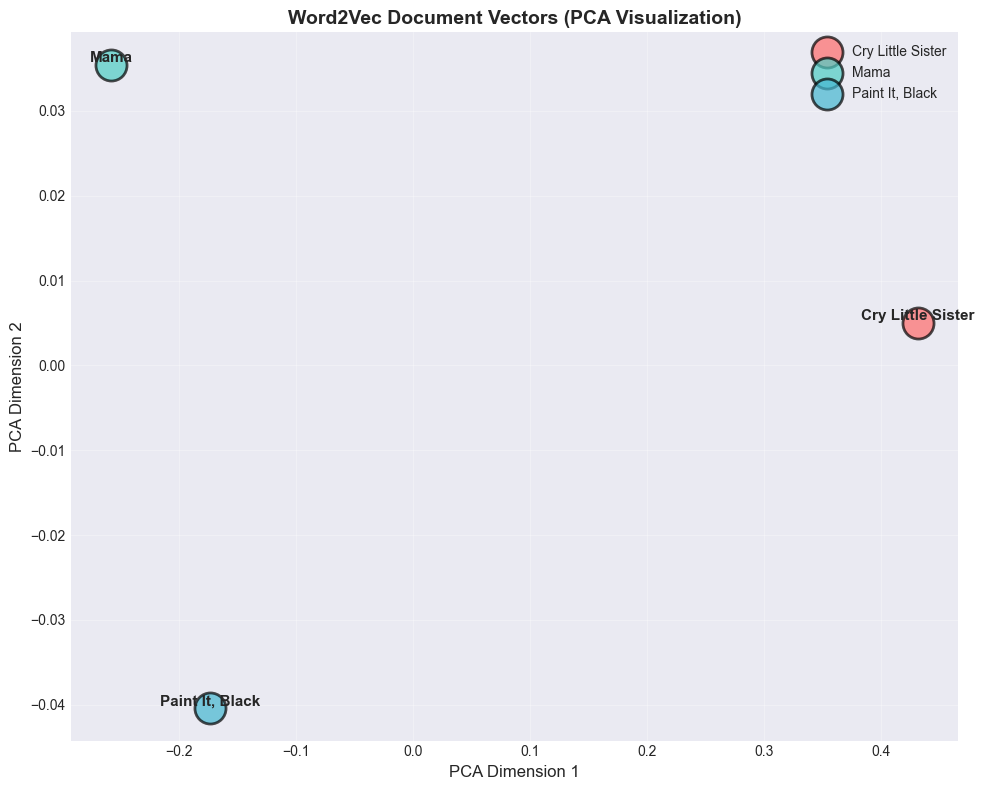

In [38]:
# Word2Vec
start_time = time.time()
word2vec_model = Word2Vec(
    sentences=tokenized_docs,
    vector_size=100, 
    window=5,
    min_count=1,
    workers=4,
    epochs=100
)
word2vec_time = time.time() - start_time

# Create document vectors by averaging word vectors
def get_doc_vector(model, tokens):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(model.vector_size)

word2vec_doc_vectors = np.array([get_doc_vector(word2vec_model, doc) for doc in tokenized_docs])
word2vec_sparsity = 0  # Dense representation

comparison_results['method'].append('Word2Vec')
comparison_results['computation_time'].append(word2vec_time)
comparison_results['matrix_shape'].append(word2vec_doc_vectors.shape)
comparison_results['sparsity'].append(word2vec_sparsity)
comparison_results['interpretability'].append('Low - Dense embeddings, not directly interpretable')
comparison_results['representation_quality'].append('High - Captures semantic relationships')

print("Word2Vec Results:")
print(f"  Computation time: {word2vec_time:.4f} seconds")
print(f"  Matrix shape: {word2vec_doc_vectors.shape}")
print(f"  Vocabulary size: {len(word2vec_model.wv)}")

# Analyze Word2Vec: Find similar words for key terms from each song
print("\n" + "="*80)
print("WORD2VEC ANALYSIS - Semantic Relationships")
print("="*80)

# Key terms from each song
key_terms = {
    'Cry Little Sister': ['sister', 'brother', 'fear', 'love', 'cry'],
    'Mama': ['mama', 'hell', 'die', 'son', 'fire'],
    'Point It, Black': ['black', 'painted', 'red', 'door', 'see']
}

for song, terms in key_terms.items():
    print(f"\n{song} - Semantic Analysis:")
    print("-" * 60)
    for term in terms:
        if term in word2vec_model.wv:
            similar = word2vec_model.wv.most_similar(term, topn=5)
            print(f"  '{term}' is similar to: {', '.join([f'{w}({s:.3f})' for w, s in similar])}")
        else:
            print(f"  '{term}' not found in vocabulary")

# Document similarity using Word2Vec
print(f"\nWord2Vec Document Similarity (Cosine Similarity):")
print("-" * 60)
word2vec_similarity = cosine_similarity(word2vec_doc_vectors)
for i, song1 in enumerate(song_df['song']):
    for j, song2 in enumerate(song_df['song']):
        if i < j:
            sim = word2vec_similarity[i, j]
            print(f"  {song1} <-> {song2}: {sim:.4f}")

# Visualize Word2Vec document vectors using PCA
pca_word2vec = PCA(n_components=2)
word2vec_2d = pca_word2vec.fit_transform(word2vec_doc_vectors)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for idx, song in enumerate(song_df['song']):
    ax.scatter(word2vec_2d[idx, 0], word2vec_2d[idx, 1], 
              s=500, c=colors[idx], label=song, alpha=0.7, edgecolors='black', linewidth=2)
    ax.annotate(song, (word2vec_2d[idx, 0], word2vec_2d[idx, 1]), 
               fontsize=11, ha='center', va='bottom', fontweight='bold')
ax.set_xlabel('PCA Dimension 1', fontsize=12)
ax.set_ylabel('PCA Dimension 2', fontsize=12)
ax.set_title('Word2Vec Document Vectors (PCA Visualization)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('word2vec_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Doc2Vec


Doc2Vec Results:
  Computation time: 0.8219 seconds
  Matrix shape: (3, 100)
  Vocabulary size: 176

DOC2VEC ANALYSIS - Document-Level Semantics

Doc2Vec Document Similarity (Cosine Similarity):
------------------------------------------------------------
  Cry Little Sister <-> Mama: 0.9201
  Cry Little Sister <-> Paint It, Black: 0.8983
  Mama <-> Paint It, Black: 0.9668

Most Similar Documents (using Doc2Vec):
------------------------------------------------------------
  'Cry Little Sister' is most similar to: 'Mama' (similarity: 0.9201)
  'Mama' is most similar to: 'Paint It, Black' (similarity: 0.9668)
  'Paint It, Black' is most similar to: 'Mama' (similarity: 0.9668)

Doc2Vec Vector Statistics:
------------------------------------------------------------
  Cry Little Sister:
    Mean: -0.0032, Std: 0.6863
    Min: -1.3649, Max: 1.5384
    Vector norm: 6.8627
  Mama:
    Mean: 0.0209, Std: 1.1819
    Min: -2.3544, Max: 2.3618
    Vector norm: 11.8206
  Paint It, Black:
    Mean:

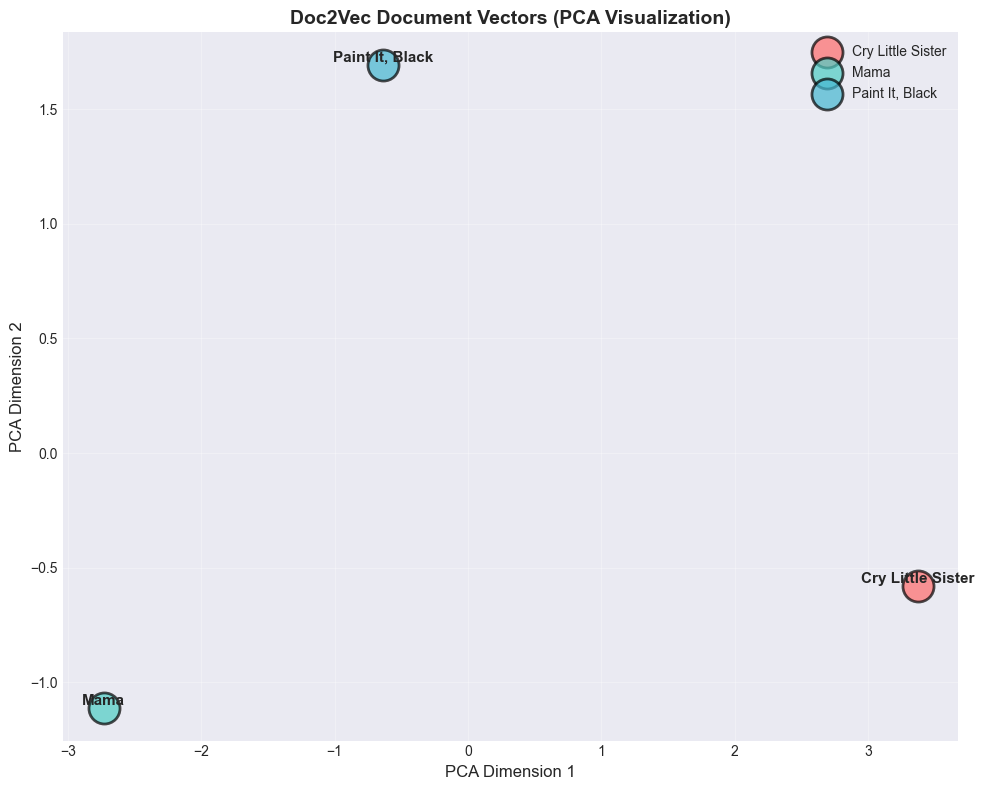

In [39]:
# Doc2Vec
start_time = time.time()
tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(tokenized_docs)]
doc2vec_model = Doc2Vec(
    documents=tagged_docs,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=100
)
doc2vec_time = time.time() - start_time

# Get document vectors
doc2vec_vectors = np.array([doc2vec_model.dv[i] for i in range(len(song_df))])
doc2vec_sparsity = 0  # Dense representation

comparison_results['method'].append('Doc2Vec')
comparison_results['computation_time'].append(doc2vec_time)
comparison_results['matrix_shape'].append(doc2vec_vectors.shape)
comparison_results['sparsity'].append(doc2vec_sparsity)
comparison_results['interpretability'].append('Low - Dense embeddings, not directly interpretable')
comparison_results['representation_quality'].append('High - Captures document-level semantics')

print("Doc2Vec Results:")
print(f"  Computation time: {doc2vec_time:.4f} seconds")
print(f"  Matrix shape: {doc2vec_vectors.shape}")
print(f"  Vocabulary size: {len(doc2vec_model.wv)}")

# Analyze Doc2Vec: Document similarity and most similar documents
print("\n" + "="*80)
print("DOC2VEC ANALYSIS - Document-Level Semantics")
print("="*80)

# Document similarity
print(f"\nDoc2Vec Document Similarity (Cosine Similarity):")
print("-" * 60)
doc2vec_similarity = cosine_similarity(doc2vec_vectors)
for i, song1 in enumerate(song_df['song']):
    for j, song2 in enumerate(song_df['song']):
        if i < j:
            sim = doc2vec_similarity[i, j]
            print(f"  {song1} <-> {song2}: {sim:.4f}")

# Find most similar documents
print(f"\nMost Similar Documents (using Doc2Vec):")
print("-" * 60)
for i, song in enumerate(song_df['song']):
    # Get similarity to other documents
    similarities = doc2vec_similarity[i]
    # Exclude self-similarity
    similarities[i] = -1
    most_similar_idx = np.argmax(similarities)
    print(f"  '{song}' is most similar to: '{song_df['song'].iloc[most_similar_idx]}' (similarity: {similarities[most_similar_idx]:.4f})")

# Analyze document vector statistics
print(f"\nDoc2Vec Vector Statistics:")
print("-" * 60)
for idx, song in enumerate(song_df['song']):
    vec = doc2vec_vectors[idx]
    print(f"  {song}:")
    print(f"    Mean: {np.mean(vec):.4f}, Std: {np.std(vec):.4f}")
    print(f"    Min: {np.min(vec):.4f}, Max: {np.max(vec):.4f}")
    print(f"    Vector norm: {np.linalg.norm(vec):.4f}")

# Visualize Doc2Vec document vectors using PCA
pca_doc2vec = PCA(n_components=2)
doc2vec_2d_pca = pca_doc2vec.fit_transform(doc2vec_vectors)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for idx, song in enumerate(song_df['song']):
    ax.scatter(doc2vec_2d_pca[idx, 0], doc2vec_2d_pca[idx, 1], 
              s=500, c=colors[idx], label=song, alpha=0.7, edgecolors='black', linewidth=2)
    ax.annotate(song, (doc2vec_2d_pca[idx, 0], doc2vec_2d_pca[idx, 1]), 
               fontsize=11, ha='center', va='bottom', fontweight='bold')
ax.set_xlabel('PCA Dimension 1', fontsize=12)
ax.set_ylabel('PCA Dimension 2', fontsize=12)
ax.set_title('Doc2Vec Document Vectors (PCA Visualization)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('doc2vec_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### 3.4 Comparison with TF-IDF


In [40]:
# TF-IDF (already computed, but adding to comparison)
tfidf_time = 0.001  # Approximate, already computed
tfidf_sparsity = 1 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))

comparison_results['method'].append('TF-IDF')
comparison_results['computation_time'].append(tfidf_time)
comparison_results['matrix_shape'].append(tfidf_matrix.shape)
comparison_results['sparsity'].append(tfidf_sparsity)
comparison_results['interpretability'].append('High - Term weights are interpretable')
comparison_results['representation_quality'].append('High - Balances term frequency with rarity')

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df


,method,computation_time,matrix_shape,sparsity,interpretability,representation_quality
0,Count Vectorizer,0.005857,"(3, 438)",0.650685,High - Direct word counts,Medium - No IDF weighting
1,Word2Vec,0.768457,"(3, 100)",0.000000,"Low - Dense embeddings, not directly interpret...",High - Captures semantic relationships
2,Doc2Vec,0.821898,"(3, 100)",0.000000,"Low - Dense embeddings, not directly interpret...",High - Captures document-level semantics
3,TF-IDF,0.001000,"(3, 438)",0.650685,High - Term weights are interpretable,High - Balances term frequency with rarity


## 4. Statistical Analysis of Transformed Data

### 4.1 Top 10 Most Frequent Words


Top 10 Most Frequent Words:
----------------------------------------
  though              :   19 occurrences
  shalt               :   19 occurrences
  mama                :   18 occurrences
  black               :   13 occurrences
  brother             :   11 occurrences
  see                 :   11 occurrences
  come                :   10 occurrences
  painted             :   10 occurrences
  sister              :    9 occurrences
  love                :    9 occurrences


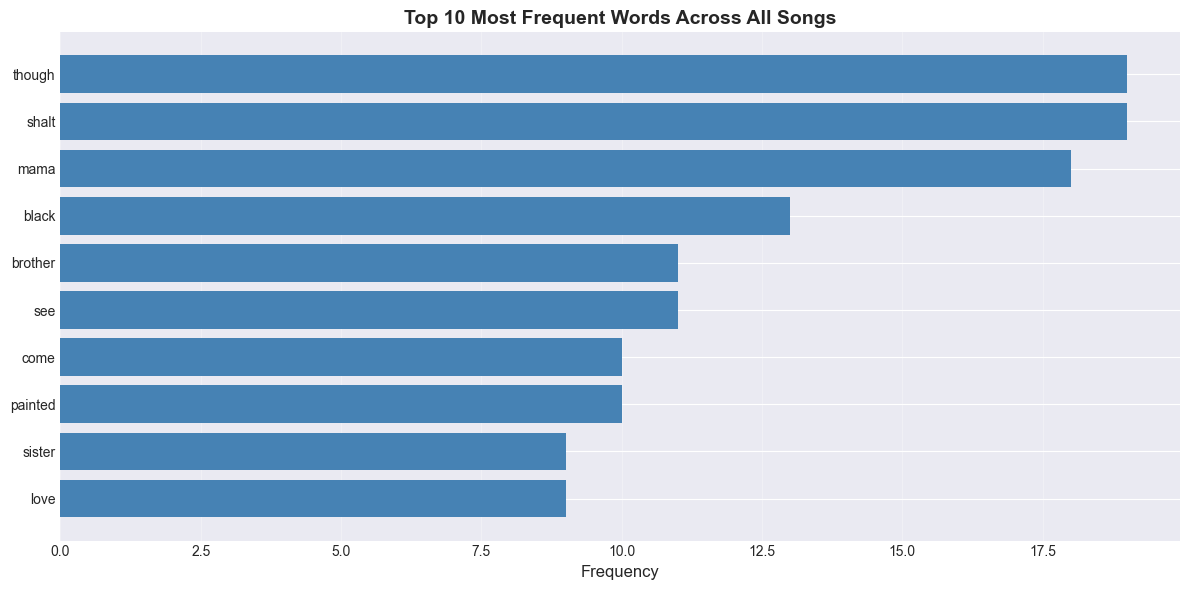

In [41]:
# Combine all processed lyrics
all_text = ' '.join(song_df['processed_lyrics'].tolist())
all_tokens = all_text.split()

# Count word frequencies
from collections import Counter
word_freq = Counter(all_tokens)

# Top 10 most frequent words
top_10_words = word_freq.most_common(10)

print("Top 10 Most Frequent Words:")
print("-" * 40)
for word, count in top_10_words:
    print(f"  {word:20s}: {count:4d} occurrences")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
words, counts = zip(*top_10_words)
ax.barh(words, counts, color='steelblue')
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title('Top 10 Most Frequent Words Across All Songs', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_10_words.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.2 Top 10 Most Frequent Word Combinations (Bigrams)


Top 10 Most Frequent Word Combinations (Bigrams):
--------------------------------------------------
  though shalt                  :   19 occurrences
  sister though                 :    9 occurrences
  brother though                :    9 occurrences
  mama hell                     :    6 occurrences
  painted black                 :    6 occurrences
  little sister                 :    5 occurrences
  shalt fall                    :    5 occurrences
  shalt fear                    :    5 occurrences
  fear love                     :    5 occurrences
  love brother                  :    5 occurrences


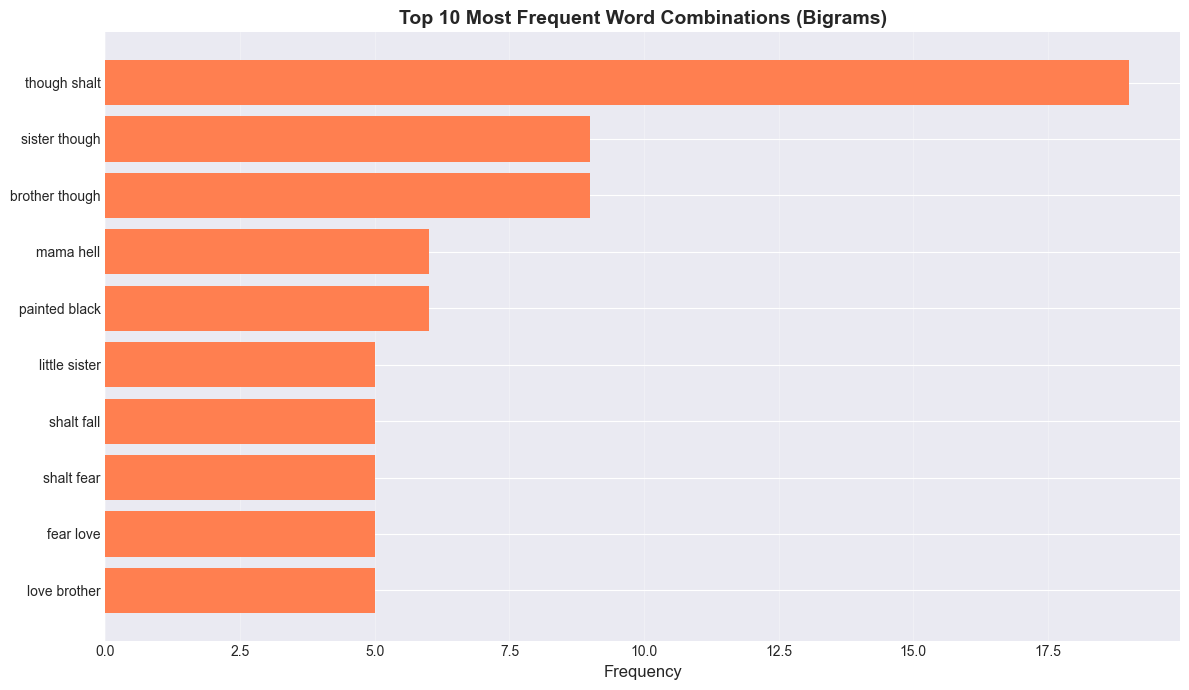

In [42]:
# Extract bigrams from all songs
from nltk import bigrams
all_bigrams = []
for lyrics in song_df['processed_lyrics']:
    tokens = lyrics.split()
    all_bigrams.extend([' '.join(bg) for bg in bigrams(tokens)])

# Count bigram frequencies
bigram_freq = Counter(all_bigrams)

# Top 10 most frequent bigrams
top_10_bigrams = bigram_freq.most_common(10)

print("Top 10 Most Frequent Word Combinations (Bigrams):")
print("-" * 50)
for bigram, count in top_10_bigrams:
    print(f"  {bigram:30s}: {count:4d} occurrences")

# Visualize
fig, ax = plt.subplots(figsize=(12, 7))
bigrams_list, counts = zip(*top_10_bigrams)
ax.barh(bigrams_list, counts, color='coral')
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title('Top 10 Most Frequent Word Combinations (Bigrams)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_10_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.3 Least Common Words (Rare Terms)


In [43]:
# Words that appear only once (hapax legomena)
rare_words = {word: count for word, count in word_freq.items() if count == 1}
print(f"Number of words appearing only once: {len(rare_words)}")
print(f"\nSample of 20 rare words:")
print("-" * 40)
for i, word in enumerate(list(rare_words.keys())[:20]):
    print(f"  {word}", end=", " if (i+1) % 5 != 0 else "\n")
print("\n")

# Words with frequency 2-3
low_freq_words = {word: count for word, count in word_freq.items() if 2 <= count <= 3}
print(f"Number of words appearing 2-3 times: {len(low_freq_words)}")

# Summary statistics
print("\n" + "="*50)
print("WORD FREQUENCY STATISTICS")
print("="*50)
print(f"Total unique words: {len(word_freq)}")
print(f"Total word occurrences: {sum(word_freq.values())}")
print(f"Words appearing once: {len(rare_words)} ({100*len(rare_words)/len(word_freq):.1f}%)")
print(f"Words appearing 2-3 times: {len(low_freq_words)} ({100*len(low_freq_words)/len(word_freq):.1f}%)")
print(f"Average frequency: {np.mean(list(word_freq.values())):.2f}")
print(f"Median frequency: {np.median(list(word_freq.values())):.1f}")


Number of words appearing only once: 110

Sample of 20 rare words:
----------------------------------------
  last,   rise,   behind,   house,   blind
  boy,   immortal,   voice,   clear,   broken
  wall,   scream,   hear,   masquerade,   stranger
  learn,   loneliness,   temptation,   heat,   beat


Number of words appearing 2-3 times: 40

WORD FREQUENCY STATISTICS
Total unique words: 176
Total word occurrences: 412
Words appearing once: 110 (62.5%)
Words appearing 2-3 times: 40 (22.7%)
Average frequency: 2.34
Median frequency: 1.0


### 4.4 WordCloud Visualization


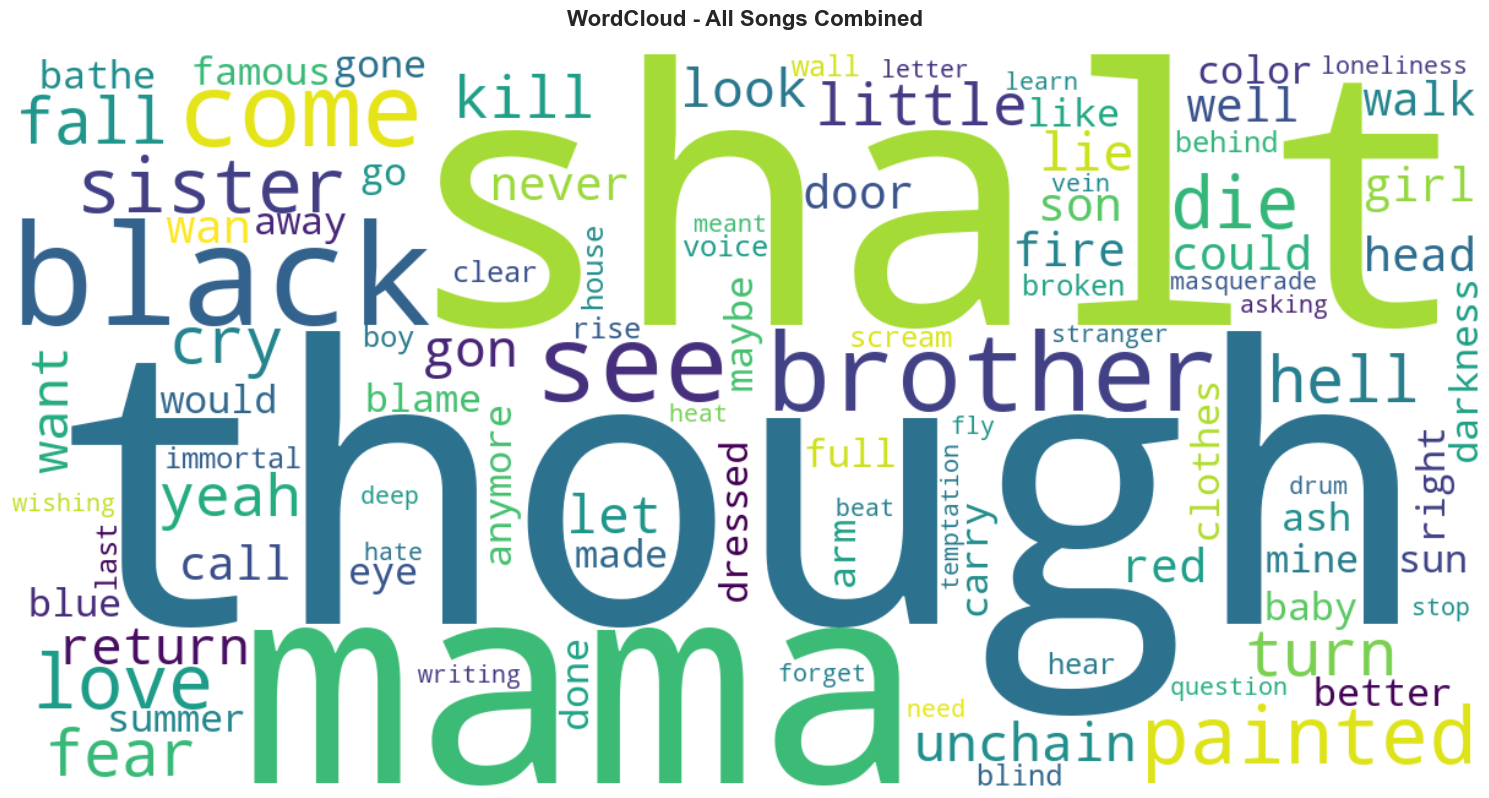

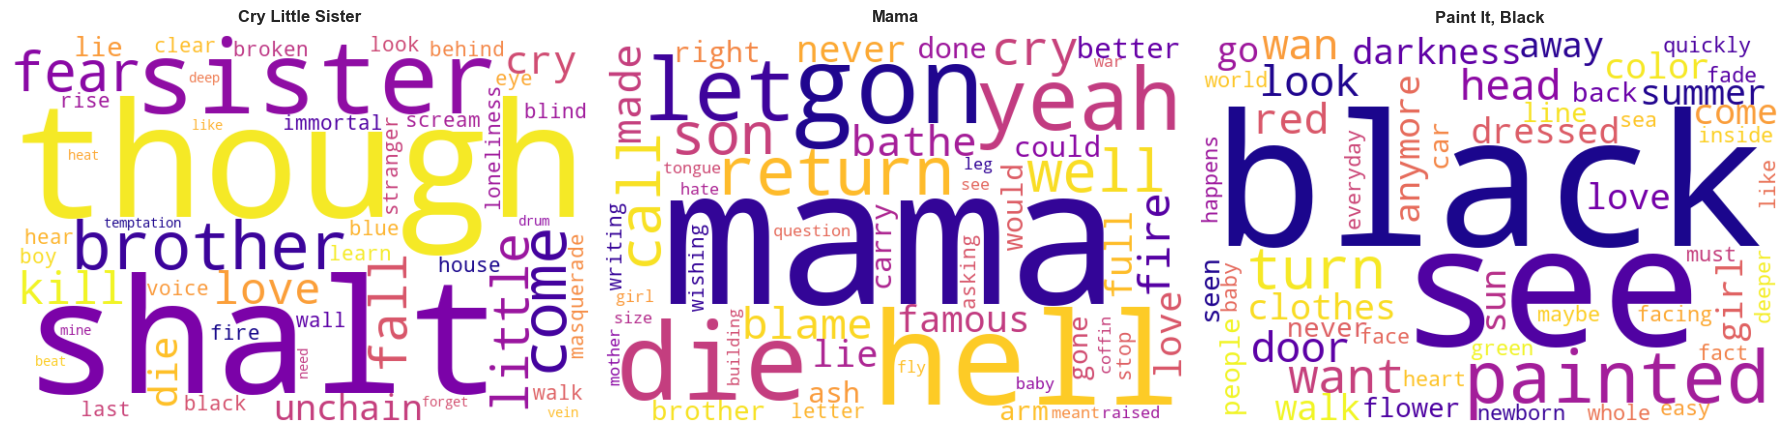

In [44]:
# Create WordCloud for all songs combined
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=100,
    colormap='viridis',
    relative_scaling=0.5
).generate_from_frequencies(word_freq)

fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('WordCloud - All Songs Combined', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('wordcloud_all_songs.png', dpi=300, bbox_inches='tight')
plt.show()

# Create individual WordClouds for each song
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, (song, lyrics) in enumerate(zip(song_df['song'], song_df['processed_lyrics'])):
    song_word_freq = Counter(lyrics.split())
    song_wordcloud = WordCloud(
        width=600,
        height=400,
        background_color='white',
        max_words=50,
        colormap='plasma',
        relative_scaling=0.5
    ).generate_from_frequencies(song_word_freq)
    
    axes[idx].imshow(song_wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(song, fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('wordcloud_per_song.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.5 t-SNE Visualization


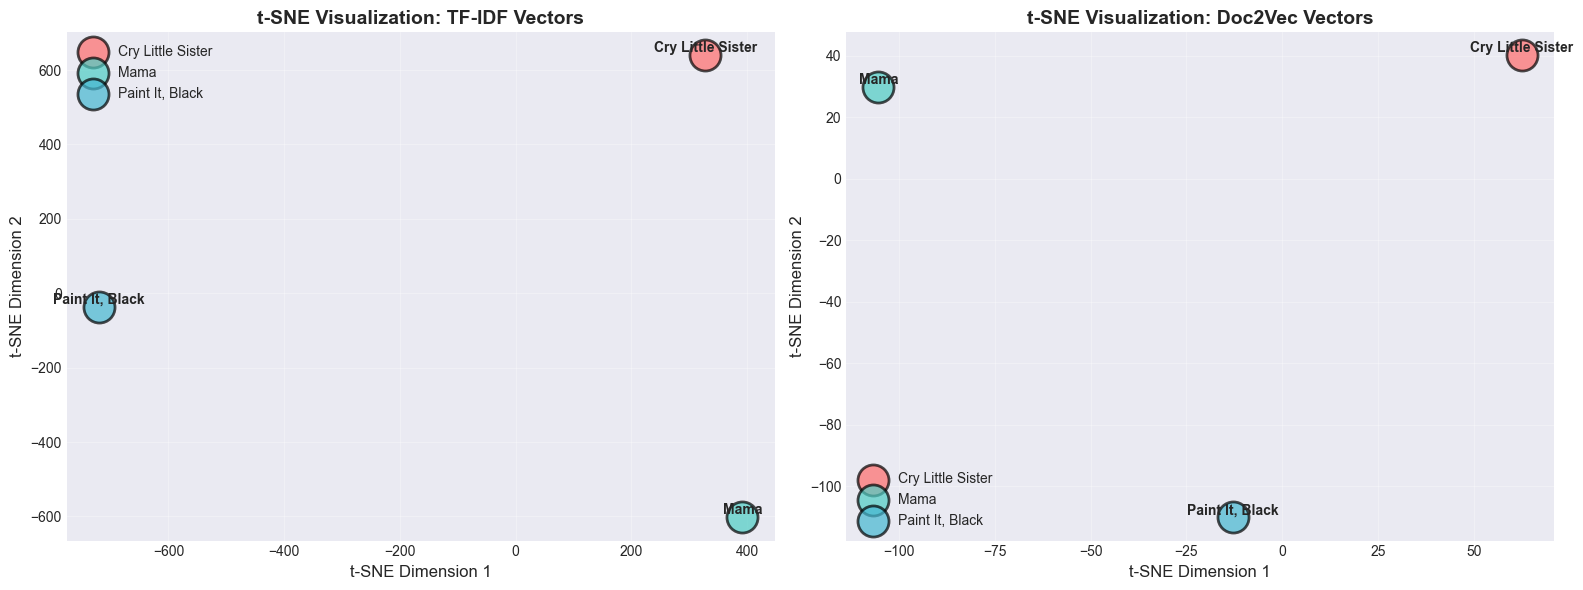

In [45]:
# Prepare data for t-SNE
# Use TF-IDF vectors for visualization
tfidf_vectors = tfidf_matrix.toarray()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
tfidf_2d = tsne.fit_transform(tfidf_vectors)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TF-IDF t-SNE
ax1 = axes[0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for idx, song in enumerate(song_df['song']):
    ax1.scatter(tfidf_2d[idx, 0], tfidf_2d[idx, 1], 
               s=500, c=colors[idx], label=song, alpha=0.7, edgecolors='black', linewidth=2)
    ax1.annotate(song, (tfidf_2d[idx, 0], tfidf_2d[idx, 1]), 
                fontsize=10, ha='center', va='bottom', fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax1.set_title('t-SNE Visualization: TF-IDF Vectors', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Doc2Vec t-SNE
tsne_doc2vec = TSNE(n_components=2, random_state=42, perplexity=2)
doc2vec_2d = tsne_doc2vec.fit_transform(doc2vec_vectors)

ax2 = axes[1]
for idx, song in enumerate(song_df['song']):
    ax2.scatter(doc2vec_2d[idx, 0], doc2vec_2d[idx, 1], 
               s=500, c=colors[idx], label=song, alpha=0.7, edgecolors='black', linewidth=2)
    ax2.annotate(song, (doc2vec_2d[idx, 0], doc2vec_2d[idx, 1]), 
                fontsize=10, ha='center', va='bottom', fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax2.set_title('t-SNE Visualization: Doc2Vec Vectors', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
